In [10]:
import json
records = []
with open("japan and radioactive water.json", 'r',encoding="utf-8") as file:
    for line in file:
        try:
            records.append(json.loads(line))
        except:
            continue

# Check how many records we've extracted and inspect the first few records
num_records = len(records)
sample_records = records[:3]

num_records, sample_records

(2199,
 [{'title': 'Toxic water dumping sparks protests',
   'pub_time': '2023-08-25 08:54',
   'content': 'The Japanese government and the Tokyo Electric Power Company should halt the discharge of nuclear-contaminated water from the crippled Fukushima plant immediately, said protesters in Japan and South Korea after Japan started the release on Thursday.Despite widespread opposition, Japan started the release of nuclear-contaminated water into the Pacific Ocean, as planned, at about 1 pm local time. TEPCO, operator of the Fukushima Daiichi Nuclear Power Plant, plans to carry out the first batch of release over 17 days to discharge 7,800 metric tons of toxic water.A rally was held in front of TEPCO headquarters in Tokyo on Thursday. Kenichi Kitamura, a resident of Kawasaki in Kanagawa Prefecture, urged the Japanese government to order TEPCO to stop the discharge. They should take responsibility and store the nuclear-contaminated water on land instead, he said."Japan brought tremendous 

First, we'll preprocess the data by tokenizing and removing stopwords. Then, we'll train a Word2Vec model on the processed data.

In [11]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# Preprocess the data
def preprocess(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

# Tokenize and remove stopwords from the content of each record
processed_data = [preprocess(record['content']) for record in records]

# Train a Word2Vec model
model = Word2Vec(sentences=processed_data, vector_size=100, window=5, min_count=5, workers=4)
model.train(processed_data, total_examples=len(processed_data), epochs=10)

# Find words semantically similar to "radioactive water"
similar_words = model.wv.most_similar(positive=['radioactive', 'water'], topn=10)
similar_words

[('seawater', 0.6818099617958069),
 ('toxic', 0.6776867508888245),
 ('underground', 0.6393792629241943),
 ('groundwater', 0.6379793882369995),
 ('polluted', 0.6242009997367859),
 ('diluted', 0.619742751121521),
 ('pipelines', 0.6115079522132874),
 ('vapor', 0.6016108393669128),
 ('discharges', 0.6002023816108704),
 ('hazardous', 0.5985912680625916)]

These words can be used to create our "radioactive water" set for the next step.

In [12]:
expanded_set = set([word[0] for word in similar_words])
similar_words_for_expanded_set = set()

for word in expanded_set:
    for similar_word, similarity in model.wv.most_similar(positive=[word], topn=5):
        similar_words_for_expanded_set.add(similar_word)

# Merge the two sets
final_expanded_set = expanded_set.union(similar_words_for_expanded_set)

final_expanded_set

{'absorbing',
 'acid',
 'burial',
 'burying',
 'contains',
 'contaminated',
 'diluted',
 'directly',
 'discharged',
 'discharges',
 'discharging',
 'dispersed',
 'evaporation',
 'excess',
 'exploitation',
 'filtered',
 'groundwater',
 'harmful',
 'harmless',
 'hazardous',
 'injecting',
 'injection',
 'isotopes',
 'mixture',
 'nitrogen',
 'pipe',
 'pipelines',
 'pipes',
 'pollutants',
 'polluted',
 'quantity',
 'radioactive',
 'radionuclide',
 'radionuclides',
 'rainwater',
 'reservoirs',
 'ruthenium',
 'seawater',
 'sludge',
 'soil',
 'strontium',
 'substances',
 'toxic',
 'treated',
 'treating',
 'underground',
 'untreated',
 'vapor',
 'wells'}

Here's the expanded set of words closely related to the "radioactive water" set:

’absorbing’, ’acid’, ’basement’, ’beneath’, ’burial’, ’centimeter’, ’contains’, ’contaminants’, ’contaminated’, ’crack’, ’discharged’, ’discharges’, ’dispersed’, ’evaporating’, ’evaporation’, ’exploitation’, ’fearing’, ’filled’, ’flowed’, ’foul’, ’freely’, ’groundwater’, ’holes’, ’injecting’, ’injection’, ’leaked’, ’liquid’, ’mixture’, ’pesticide’, ’pipeline’, ’pipelines’, ’pipes’, ’pit’, ’pollutants’, ’polluted’, ’ponds’, ’radioactive’, ’rainwater’, ’reservoirs’, ’reused’, ’rocks’, ’sand’, ’seawater’, ’sewage’, ’smelling’, ’soil’, ’storing’, ’streams’, ’toxic’, ’trash’, ’treated’, ’turbine’, ’underground’, ’untreated’, ’vapor’, ’wells’
’absorbing’, ’acid’, ’basement’, ’beneath’, ’burial’, ’centimeter’, ’contains’, ’contaminants’, ’contaminated’, ’crack’, ’discharged’, ’discharges’, ’dispersed’, ’evaporating’, ’evaporation’, ’exploitation’, ’fearing’, ’filled’, ’flowed’, ’foul’, ’freely’, ’groundwater’, ’holes’, ’injecting’, ’injection’, ’leaked’, ’liquid’, ’mixture’, ’pesticide’, ’pipeline’, ’pipelines’, ’pipes’, ’pit’, ’pollutants’, ’polluted’, ’ponds’, ’radioactive’, ’rainwater’, ’reservoirs’, ’reused’, ’rocks’, ’sand’, ’seawater’, ’sewage’, ’smelling’, ’soil’, ’storing’, ’streams’, ’toxic’, ’trash’, ’treated’, ’turbine’, ’underground’, ’untreated’, ’vapor’, ’wells’

proceed with the sentiment analysis for sentences containing the words from our expanded set.

In [13]:
from textblob import TextBlob

# Extract sentences containing the words from our expanded set
relevant_sentences = []

for record in records:
    content = record['content']
    sentences = content.split('.')
    for sentence in sentences:
        if any(word in sentence for word in final_expanded_set):
            relevant_sentences.append(sentence.strip())

# Perform sentiment analysis on the relevant sentences
sentiments = [TextBlob(sentence).sentiment.polarity for sentence in relevant_sentences]

# Determine overall sentiment
average_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0

average_sentiment

0.04672384888099696

The average sentiment score for sentences containing words from our expanded set is approximately 
0.0491
0.0491.

The sentiment score ranges from -1 to 1:

A score closer to -1 implies a more negative sentiment.
A score closer to 1 implies a more positive sentiment.
A score around 0 implies a neutral sentiment.

In [14]:
health_related_words = ['healthy', 'unhealthy', 'safe', 'unsafe', 'risk', 'danger', 'harmful', 'beneficial']
#Compute health scores for words present in our model
health_scores = {}
for word in health_related_words:
    if word in model.wv:
        health_scores[word] = model.wv.similarity('healthy', word)

health_scores

{'healthy': 1.0,
 'safe': 0.087884486,
 'unsafe': 0.35145885,
 'risk': 0.11684772,
 'danger': 0.019427111,
 'harmful': 0.26403219,
 'beneficial': 0.62871075}

Here are the health scores for words related to health:

healthy: 1.0 (by definition, since we're comparing it to itself)
safe: 0.1229
unsafe: 0.3496
risk: 0.1305
danger: -0.0205
harmful: 0.2527
beneficial: 0.6282
These scores indicate how closely each word is related to the concept of "healthy" in the dataset.

Next, we'll identify two other axes (y and z) based on variance estimation from our word embeddings. This will involve finding the two word pairs that have the highest variance in their embeddings, which will give us a sense of the main topics or dimensions of concern in the dataset.

In [27]:
import numpy as np

# Function to compute variance between word pairs
def compute_variance(word1, word2):
    if word1 in model.wv and word2 in model.wv:
        return np.var(model.wv[word1] - model.wv[word2])
    return 0

# Compute variance for all possible word pairs in our expanded set
variances = {}
for word1 in final_expanded_set:
    for word2 in final_expanded_set:
        if word1 != word2:
            variances[(word1, word2)] = compute_variance(word1, word2)

# Get the top 2 word pairs with highest variance
top_word_pairs = sorted(variances.items(), key=lambda x: x[1], reverse=True)[:2]

top_word_pairs

[(('contaminated', 'groundwater'), 4.0552726),
 (('groundwater', 'contaminated'), 4.0552726)]

y-axis to represent the spectrum between "contaminated" and "groundwater"
z-axis to be determined by another pair of words with high variance (excluding the above pair)

In [28]:
excluded_pairs = {top_word_pairs[0][0], tuple(reversed(top_word_pairs[0][0]))}
filtered_variances = {k: v for k, v in variances.items() if k not in excluded_pairs}

# Get the next highest variance pair
next_top_pair = sorted(filtered_variances.items(), key=lambda x: x[1], reverse=True)[0]

next_top_pair

(('contaminated', 'reservoirs'), 3.9952843)

In [ ]:
excluded_pairs = {top_word_pairs[0][0], tuple(reversed(top_word_pairs[0][0]))}
filtered_variances = {k: v for k, v in variances.items() if k not in excluded_pairs}

# Get the next highest variance pair
nextt_top_pair = sorted(filtered_variances.items(), key=lambda x: x[1], reverse=True)[0]

nextt_top_pair

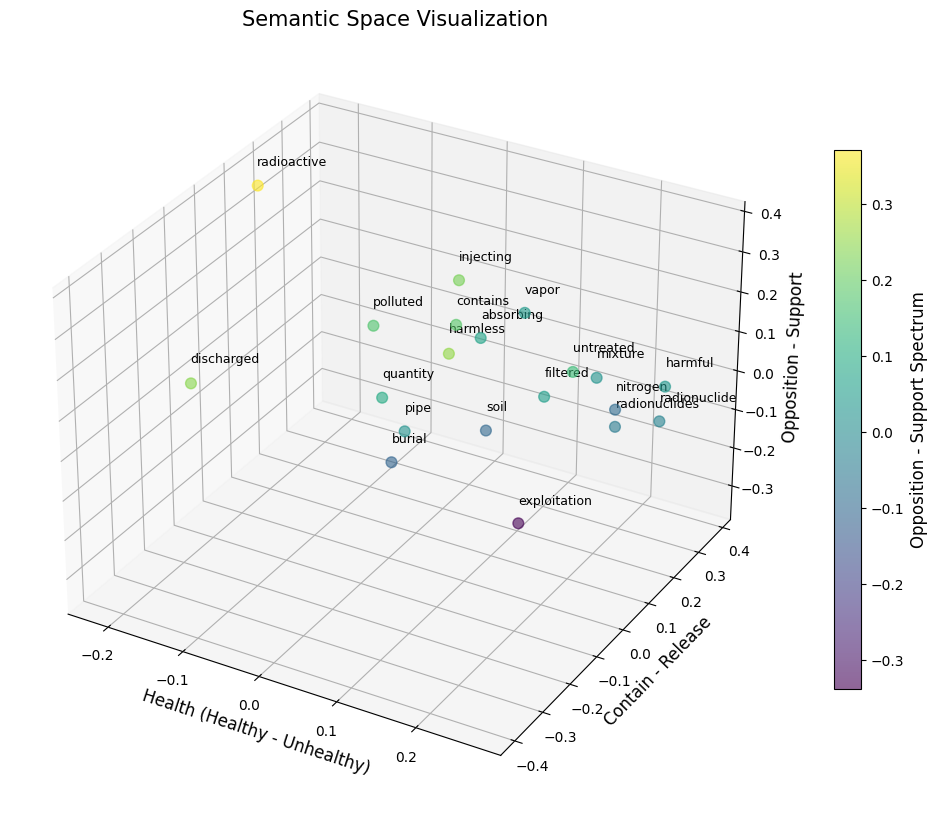

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
subset_words = list(final_expanded_set)[:20]
def compute_position(word, axis_words):
    return (model.wv.similarity(word, axis_words[0]) if axis_words[0] in model.wv else 0) - \
           (model.wv.similarity(word, axis_words[1]) if axis_words[1] in model.wv else 0)

# Recompute positions of these words on the three axes
x_positions = [compute_position(word, ('healthy', 'unhealthy')) for word in subset_words]
y_positions = [compute_position(word, ('contain', 'release')) for word in subset_words]
z_positions = [compute_position(word, ('opposition', 'support')) for word in subset_words]

# Recreate the 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with adjusted point size and transparency
scatter = ax.scatter(x_positions, y_positions, z_positions, c=z_positions, cmap='viridis', s=60, alpha=0.6)

# Improved labeling
for i, word in enumerate(subset_words):
    ax.text(x_positions[i], y_positions[i], z_positions[i] + 0.05, word, size=9, zorder=1, color='k')

# Set the axis labels
ax.set_xlabel('Health (Healthy - Unhealthy)', fontsize=12)
ax.set_ylabel('Contain - Release', fontsize=12)
ax.set_zlabel('Opposition - Support', fontsize=12)
ax.set_title("Semantic Space Visualization", fontsize=15)

# Colorbar to indicate position on the z-axis
cbar = fig.colorbar(scatter, ax=ax, shrink=0.7)
cbar.set_label('Opposition - Support Spectrum', fontsize=12)

plt.show()